In [1]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torch import from_numpy
from skimage.color import rgb2lab
import torch.nn as nn
import torch.nn.functional as F
from torch import cat
import os
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import load, no_grad
from skimage.color import lab2rgb
import json
import torch.optim as optim
from torch import save
import time
from torchvision import transforms
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict
import warnings

In [2]:
device = "cuda"
warnings.filterwarnings("ignore")

In [3]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)

        # Dilation layers.
        self.conv5 = nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=3, dilation=2)
        self.conv5_bn = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=3, dilation=2)
        self.conv6_bn = nn.BatchNorm2d(256)

        self.t_conv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.t_conv1_bn = nn.BatchNorm2d(128)
        self.t_conv2 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)
        self.t_conv2_bn = nn.BatchNorm2d(64)
        self.t_conv3 = nn.ConvTranspose2d(128, 32, kernel_size=4, stride=2, padding=1)
        self.t_conv3_bn = nn.BatchNorm2d(32)
        self.t_conv4 = nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1)

        self.output = nn.Conv2d(3, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x_1 = F.relu(self.conv1_bn(self.conv1(x)))
        x_2 = F.relu(self.conv2_bn(self.conv2(x_1)))
        x_3 = F.relu(self.conv3_bn(self.conv3(x_2)))
        x_4 = F.relu(self.conv4_bn(self.conv4(x_3)))

        x_5 = F.relu(self.conv5_bn(self.conv5(x_4)))
        x_5_d = F.relu(self.conv6_bn(self.conv6(x_5)))
        x_6 = F.relu(self.t_conv1_bn(self.t_conv1(x_5_d)))
        x_6 = cat((x_6, x_3), 1)
        x_7 = F.relu(self.t_conv2_bn(self.t_conv2(x_6)))
        x_7 = cat((x_7, x_2), 1)
        x_8 = F.relu(self.t_conv3_bn(self.t_conv3(x_7)))
        x_8 = cat((x_8, x_1), 1)
        x_9 = F.relu(self.t_conv4(x_8))
        x_9 = cat((x_9, x), 1)
        x = self.output(x_9)
        return x

In [4]:


class ImageDataset(Dataset):
    def __init__(self, color_dir, gray_dir=None, transform=None, target_transform=None):
        """
        :param color_dir: The directory where the colored images or directories of images are located at.
        :param gray_dir: (Optional) The directory where the gray image are located at.
        When this parameter is not set, LAB format is used. Otherwise, RGB is used.
        :param transform: (Optional) `transform` function to be applied on a gray image.
        :param target_transform: (Optional) `transform` function to be applied on a colored image.
        """
        self.color_dir = color_dir
        self.gray_dir = gray_dir
        self.transform = transform
        self.target_transform = target_transform

        # If color_dir contains subdirectories, get all image files from those subdirectories
        if os.path.isdir(color_dir):
            color_files = []
            for root, dirs, files in os.walk(color_dir):
                for file in files:
                    if file.endswith(('.jpg', '.jpeg', '.png')):
                        color_files.append(os.path.join(root, file))
            self.color_files = color_files
        else:
            raise ValueError("color_dir must be a directory containing images or directories of images.")

        if gray_dir is not None:
            self.gray_files = [os.path.join(gray_dir, file) for file in os.listdir(gray_dir)[:4]]

    def __len__(self):
        """
        Returns the length of the dataset.
        :return: The length of the dataset.
        """
        return len(self.color_files)

    def __getitem__(self, index):
        """
        Fetches the item of the given index.
        :param index: The index where the item is located at.
        :return: The item in the given index.
        """
        color_path = self.color_files[index]
        resize = transforms.Resize((128, 128)) 

        if self.gray_dir is not None:
            gray_path = self.gray_files[index]
            gray_image = read_image(gray_path, ImageReadMode.GRAY)
            
            color_path = os.path.join(self.color_dir, self.names[index])
            color_image = resize(read_image(color_path))
        else:

            image = from_numpy(rgb2lab(resize(read_image(color_path)).permute(1, 2, 0))).permute(2, 0, 1)

            color_image = image[1:, :, :]
            gray_image = image[0, :, :].unsqueeze(0)

        if self.transform:
            gray_image = self.transform(gray_image)
        if self.target_transform:
            color_image = self.target_transform(color_image)

        return gray_image, color_image


In [5]:
def plot_loss(loss, title, filename):
    """
    Plots the loss for each epoch.
    :param loss: A list with the loss per epoch.
    :param title: The plot title.
    :param filename: The filename.
    """
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.savefig(f"/kaggle/working/{filename}.png")
    plt.show()

def instantiate_network():
    """
    Instantiates the network 
    :return: The network.
    """
    return Network()


def register_hooks(model, hook):
    """
    Registers the given hook to the given model.
    :param model: The model.
    :param hook: The hook to be registered.
    :return: The model instance and the layers list.
    """
    layers = []
   
    model.conv1.register_forward_hook(hook("conv1"))
    model.conv2.register_forward_hook(hook("conv2"))
    model.conv3.register_forward_hook(hook("conv3"))
    model.conv4.register_forward_hook(hook("conv4"))
    model.conv5.register_forward_hook(hook("conv5"))
    model.conv6.register_forward_hook(hook("conv6"))
    model.t_conv1.register_forward_hook(hook("t_conv1"))
    model.t_conv2.register_forward_hook(hook("t_conv2"))
    model.t_conv3.register_forward_hook(hook("t_conv3"))
    model.t_conv4.register_forward_hook(hook("t_conv4"))
    model.output.register_forward_hook(hook("output"))

    layers = [
            {
                "name": "conv1",
                "channels": model.conv1.out_channels
            },
            {
                "name": "conv2",
                "channels": model.conv2.out_channels
            },
            {
                "name": "conv3",
                "channels": model.conv3.out_channels
            },
            {
                "name": "conv4",
                "channels": model.conv4.out_channels
            },
            {
                "name": "conv5",
                "channels": model.conv5.out_channels
            },
            {
                "name": "conv6",
                "channels": model.conv6.out_channels
            },
            {
                "name": "t_conv1",
                "channels": model.t_conv1.out_channels
            },
            {
                "name": "t_conv2",
                "channels": model.t_conv2.out_channels
            },
            {
                "name": "t_conv3",
                "channels": model.t_conv3.out_channels
            },
            {
                "name": "t_conv4",
                "channels": model.t_conv4.out_channels
            },
            {
                "name": "output",
                "channels": model.output.out_channels
            }
        ]

    return model, layers

In [6]:
def train_model(color_dir, gray_dir=None, epochs=10, learning_rate=0.001, file_name="cnn", model=None):
    """
    Trains the model with the given examples.
    :param color_dir: The directory where the colored images are stored.
    :param gray_dir: The directory where the gray images are stored.
    :param epochs: The number of epochs.
    :param learning_rate: The learning rate.
    :param file_name: The file name prefix to be used for storing model and
    results.
    :param model: (Optional) The pre-trained model.
    """

    training_data = ImageDataset(color_dir=color_dir, gray_dir=gray_dir)
    train_data_loader = DataLoader(training_data, batch_size=32, shuffle=True)

    cnn = instantiate_network().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    cnn = nn.DataParallel(cnn)
    running_losses = []
    scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.7)
    # Checking if there is a pre-trained model to be loaded.
    if model is not None:
        checkpoint = load(model)
        cnn.load_state_dict(checkpoint["model_state_dict"]).to(device)
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        cnn.eval()
        cnn.train()
        initial_time = checkpoint["time"]
        running_losses = checkpoint["running_losses"]
    else:
        initial_time = 0

    print(f"Number of parameters: {sum(p.numel() for p in cnn.parameters())}")

    start = time.time()
    for epoch in range(epochs):
        epoch_running_loss = 0
        for i, data in enumerate(train_data_loader, 0):
            gray, color = data
            gray = gray.float()
            color = color.float()
            gray, color = gray.to(device), color.to(device)
            
            outputs = cnn(gray)

            optimizer.zero_grad()
            loss = criterion(outputs, color)
            loss.backward()
            optimizer.step()

            epoch_running_loss += loss.item()
            if i % 20 == 0: 
                print(f'[Epoch:{epoch + 1}, batch:{i + 1:5d}] loss: {loss.item():.5f}')
        epoch_running_loss /= len(train_data_loader)
        running_losses.append(epoch_running_loss)
        scheduler.step()
        if epoch % 10 == 9:
            save({
                "epoch": epoch,
                "model_state_dict": cnn.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "time": time.time() - start + initial_time,
                "running_losses": running_losses
            }, f"./{file_name}_{learning_rate}_{epoch}.pt")
        print(f"Epoch: {epoch + 1}/{epochs}, Running Loss: {epoch_running_loss}")

    print("Finished")
    plot_loss(running_losses,"Training MSE Loss",f'{file_name}_{learning_rate}_loss_plot' )
    results = {"losses": running_losses}

    # Store losses in json file
    with open(f"/kaggle/working/training_{file_name}_{learning_rate}_losses.json", "w") as results_file:
        json.dump(results, results_file)

    save({
        "epoch": epoch,
        "model_state_dict": cnn.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "time": time.time() - start + initial_time,
        "running_losses": running_losses
    }, f"./{file_name}_{learning_rate}_full.pt")
    print(f"./{file_name}_{learning_rate}_full.pt")

In [7]:
def test_model(model_file, file_name, color_dir, gray_dir=None, show_images=True):
    """
    Tests the given model against the given images.
    :param model_file: The file where the model is stored.
    :param file_name: The file name prefix to be used to save images.
    :param color_dir: The directory where the colored images are stored.
    :param gray_dir: The directory where the gray images are stored.
    :param show_images: Determines if the comparison images will be saved.
    """
    # Loading Dataset and creating the corresponding DataLoader.
    data = ImageDataset(color_dir=color_dir, gray_dir=gray_dir)
    data_loader = DataLoader(data, batch_size=5, shuffle=True)

    # Loading the NN and passing the data.
    state_dict = load(model_file)["model_state_dict"]
    # create new OrderedDict that does not contain `module.`

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
# load params
    cnn = instantiate_network()
    cnn.load_state_dict(new_state_dict)

    # Grid setup.
    columns = 5
    rows = 3

    data_iterator = iter(data_loader)

    total_loss = 0
    some = 0
    # Creating an image grid to showcase the results.
    j = 0
    while j <= 5:
        gray, color = next(data_iterator, None) or (None, None)
        if gray is None:
            break

        outputs = cnn(gray.float())
        outputs = outputs.int()

        # Removing the channel.
        gray_images = gray.squeeze()

        if show_images:
            fig = plt.figure(figsize=(8, 8))

        # First row consists of the gray images.
        for i in range(1, columns + 1):
            if show_images:
                fig.add_subplot(rows, columns, i)
            img = gray_images[i - 1]

            # Setting the title on top of the middle image.
            if i == 3:
                plt.title("Input")

            plt.gca().get_xaxis().set_visible(False)
            plt.gca().get_yaxis().set_visible(False)
            if show_images:
                plt.imshow(img, cmap="gray")

        # Second row consists of the actual colored images.
        for i in range(1, columns + 1):
            if show_images:
                fig.add_subplot(rows, columns, i + columns)
            # Setting the title on top of the middle image.
            if i == 3:
                plt.title("Actual")

            if gray_dir is not None:
                img = color[i - 1].permute(1, 2, 0)
            else:
                img = cat((gray[i - 1], color[i - 1]), 0)
                img = lab2rgb(img.permute(1, 2, 0))
            plt.gca().get_xaxis().set_visible(False)
            plt.gca().get_yaxis().set_visible(False)
            if show_images:
                plt.imshow(img)

        # Third row consists of the predicted colored images.
        with no_grad():
            for i in range(1, columns + 1):
                if show_images:
                    fig.add_subplot(rows, columns, i + 2 * columns)
                mse = nn.MSELoss()

                if gray_dir is not None:
                    img = outputs[i - 1].permute(1, 2, 0)
                    loss = mse(outputs[i - 1], color[i - 1])
                else:
                    img = cat((gray[i - 1], outputs[i - 1]), 0)
                    img = lab2rgb(img.permute(1, 2, 0))
                    img_true = cat((gray[i - 1], color[i - 1]), 0)
                    img_true = lab2rgb(img_true.permute(1, 2, 0))
                    loss = mse(from_numpy(img).permute(2, 0, 1), from_numpy(img_true).permute(2, 0, 1))
                total_loss += loss.item()
                plt.gca().get_yaxis().set_visible(False)
                plt.gca().set_xticks([])
                plt.gca().set_xlabel(f"{loss.item():.5f}")

                # Setting the title on top of the middle image.
                if i == 3:
                    plt.title("Predicted")

                if show_images:
                    plt.imshow(img)

        if show_images:
            plt.savefig(f"/kaggle/working/testing_{file_name}_{j}.png")
        j += 1

    # Store total loss in json file
    with open(f"/kaggle/working/testing_{file_name}_total_loss.json", "w") as results_file:
        json.dump({"total_loss": total_loss}, results_file)



def render_layer_output(model_file, file_name, color_dir, number_of_filters):
    """
    Renders the output of each layer.
    :param model_file: The file where the model is stored.
    :param file_name: The file name prefix to be used to store the images.
    :param color_dir: The directory where the colored images are stored.
    :param number_of_filters: The number of filters to be rendered on the images.
    """
    data = ImageDataset(color_dir=color_dir, gray_dir=None)
    data_loader = DataLoader(data, batch_size=1, shuffle=True)

    # Setting up activation hooks.
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()

        return hook

    
    # Loading the NN and passing the data.
    state_dict = load(model_file)["model_state_dict"]
    # create new OrderedDict that does not contain `module.`

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    # load params
    cnn = instantiate_network()
    cnn, layers = register_hooks(cnn , get_activation)
    cnn.load_state_dict(new_state_dict)

    gray, color = next(iter(data_loader), None)

    # Feeding the data to the neural network.
    cnn(gray.float())

    # Grid setup.
    columns = 5
    rows = int((number_of_filters + 1)/5 + 1)

    for layer in layers:
        fig = plt.figure(figsize=(8, 8))
        plt.title(layer["name"])
        # Adding the actual colored image.
        with no_grad():
            fig.add_subplot(rows, columns, 1)
            plt.gca().get_xaxis().set_visible(False)
            plt.gca().get_yaxis().set_visible(False)
            img = cat((gray[0], color[0]), 0)
            img = lab2rgb(img.permute(1, 2, 0))
            plt.imshow(img)

        # First row consists of the gray images.
        for i in range(1, min(number_of_filters, layer["channels"]) + 1):
            fig.add_subplot(rows, columns, i + 1)
            plt.gca().get_xaxis().set_visible(False)
            plt.gca().get_yaxis().set_visible(False)
            plt.imshow(activation[layer["name"]][0][i - 1])
        plt.savefig(f"/kaggle/working/layers_{file_name}_{layer['name']}.png")

Number of parameters: 3643514
[Epoch:1, batch:    1] loss: 225.59567
[Epoch:1, batch:   21] loss: 207.52669
[Epoch:1, batch:   41] loss: 264.02402
[Epoch:1, batch:   61] loss: 174.60443
[Epoch:1, batch:   81] loss: 165.15335
[Epoch:1, batch:  101] loss: 173.54541
[Epoch:1, batch:  121] loss: 166.09975
[Epoch:1, batch:  141] loss: 120.67398
[Epoch:1, batch:  161] loss: 143.91403
[Epoch:1, batch:  181] loss: 108.23776
[Epoch:1, batch:  201] loss: 166.87402
[Epoch:1, batch:  221] loss: 161.58463
[Epoch:1, batch:  241] loss: 115.93217
[Epoch:1, batch:  261] loss: 183.88029
[Epoch:1, batch:  281] loss: 147.85370
[Epoch:1, batch:  301] loss: 96.69335
[Epoch:1, batch:  321] loss: 143.62767
[Epoch:1, batch:  341] loss: 118.39618
[Epoch:1, batch:  361] loss: 176.60213
[Epoch:1, batch:  381] loss: 132.65433
[Epoch:1, batch:  401] loss: 133.99161
[Epoch:1, batch:  421] loss: 152.01544
Epoch: 1/50, Running Loss: 142.04182898102155
[Epoch:2, batch:    1] loss: 181.82330
[Epoch:2, batch:   21] loss:

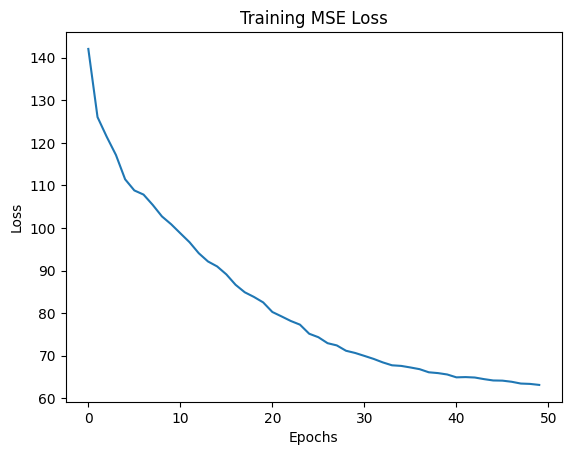

./cnn_new_0.001_full.pt


In [8]:
train_model("/kaggle/input/intel-image-classification/seg_train/seg_train", None, 50, file_name = "cnn_new")

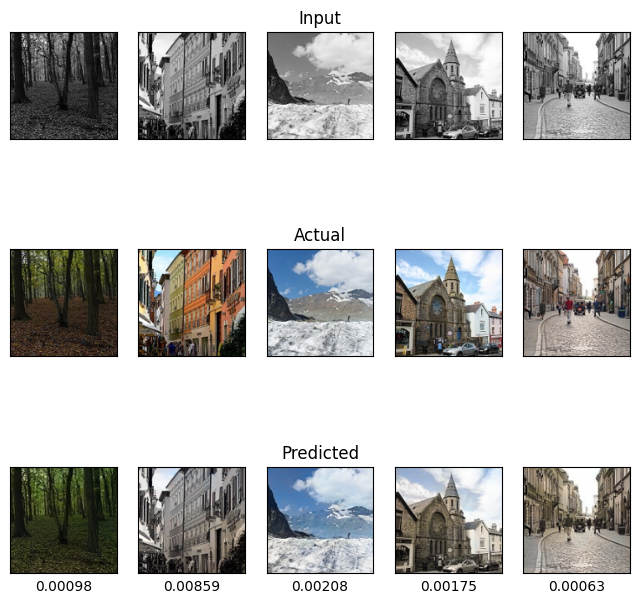

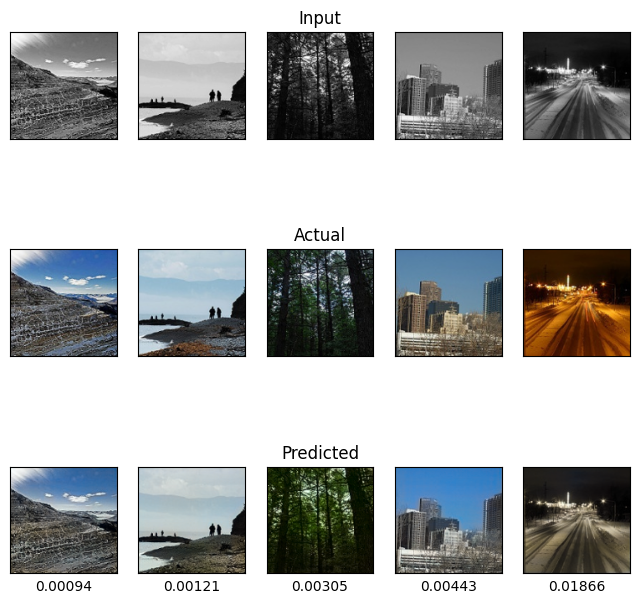

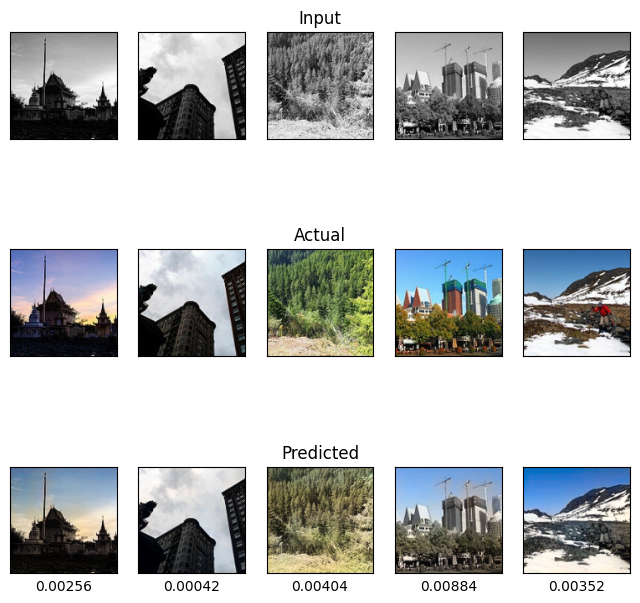

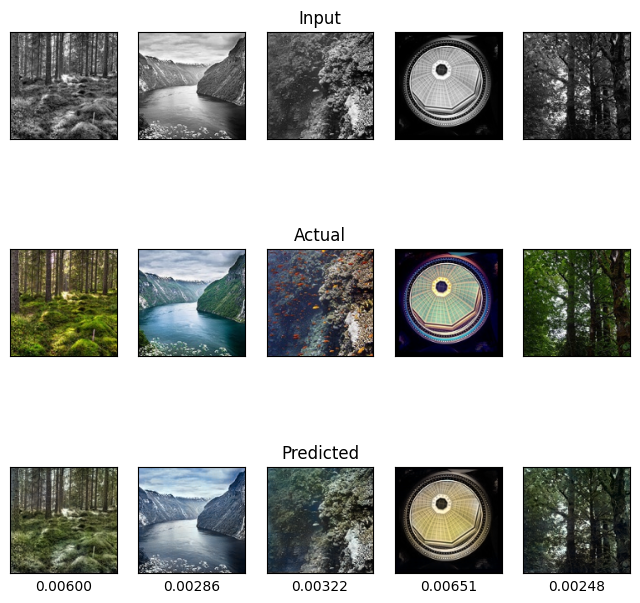

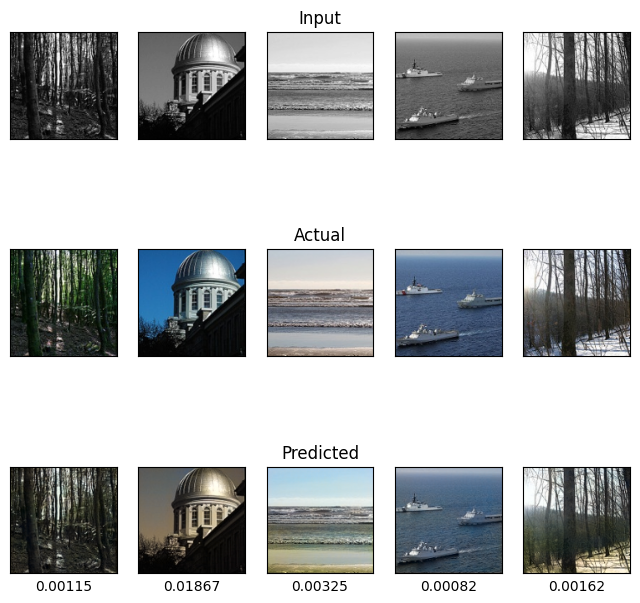

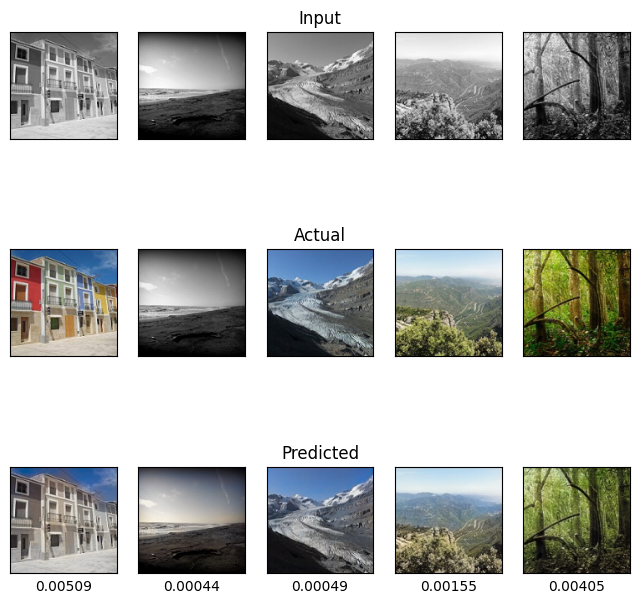

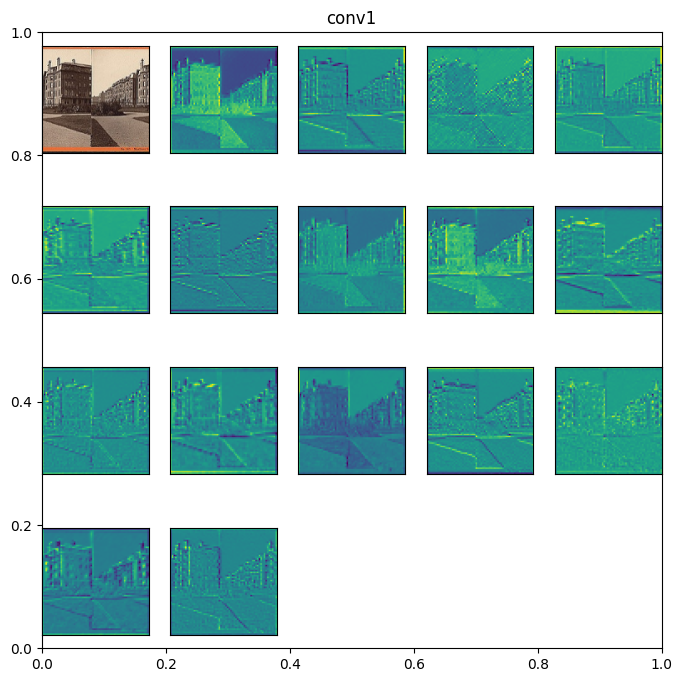

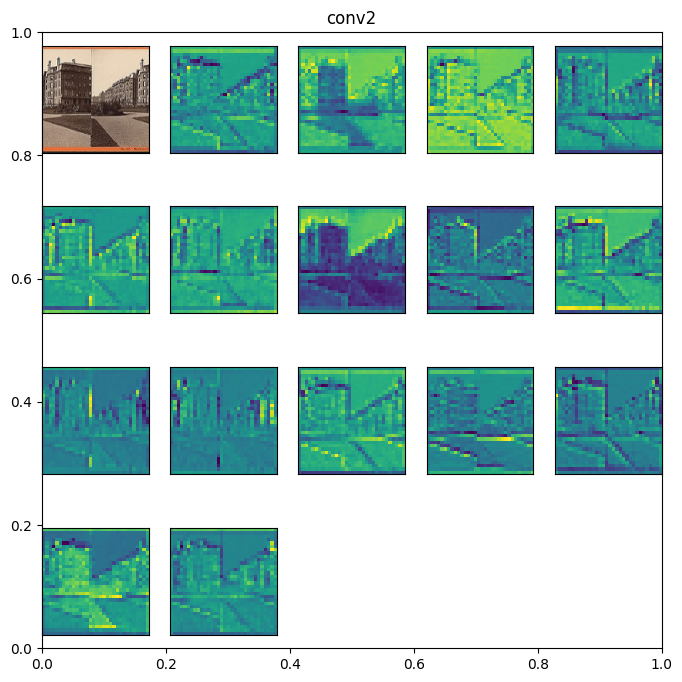

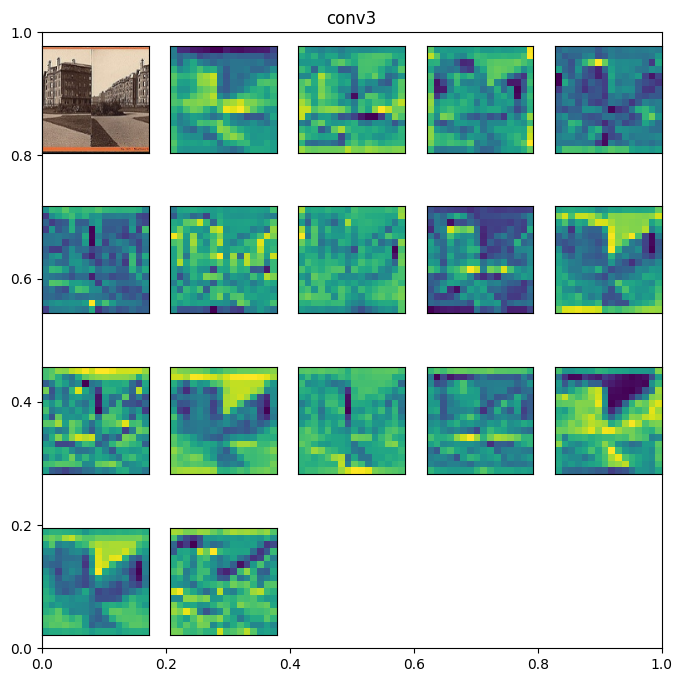

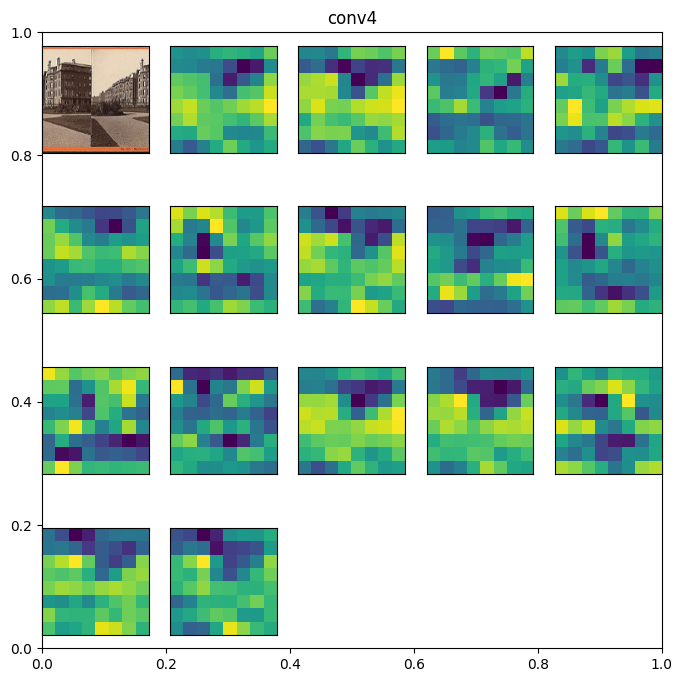

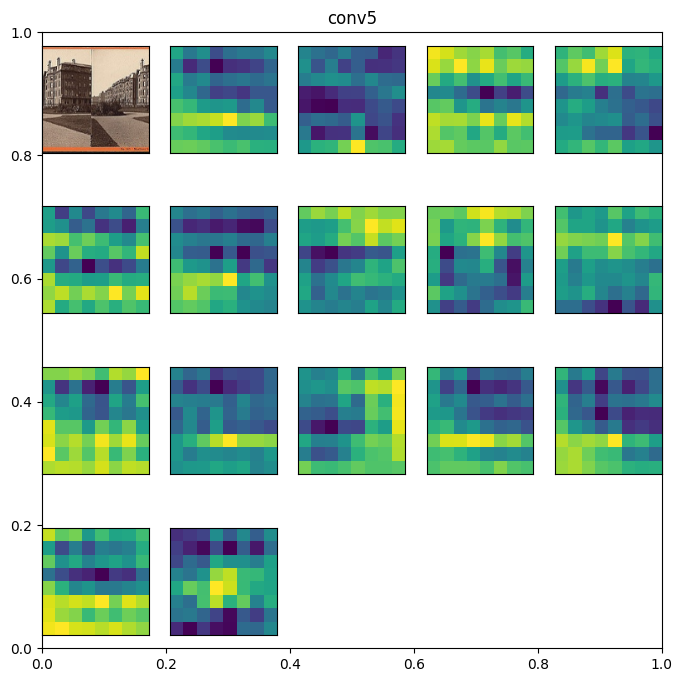

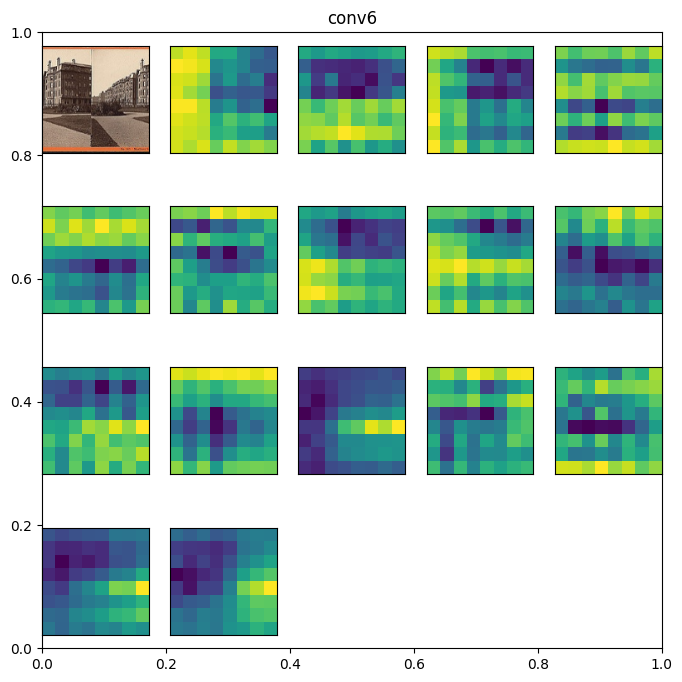

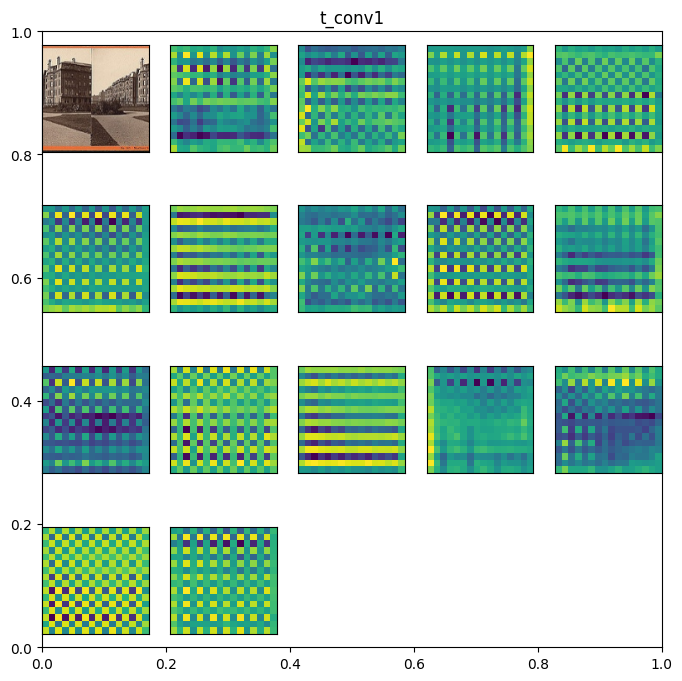

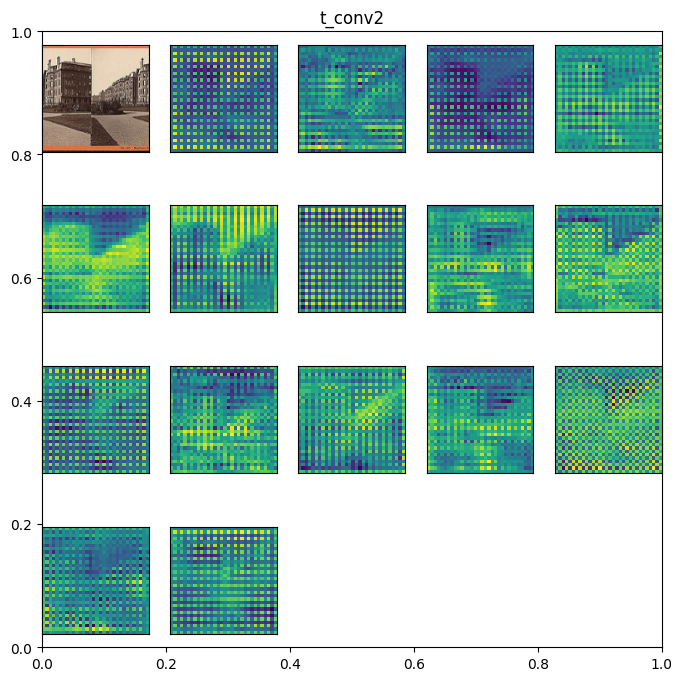

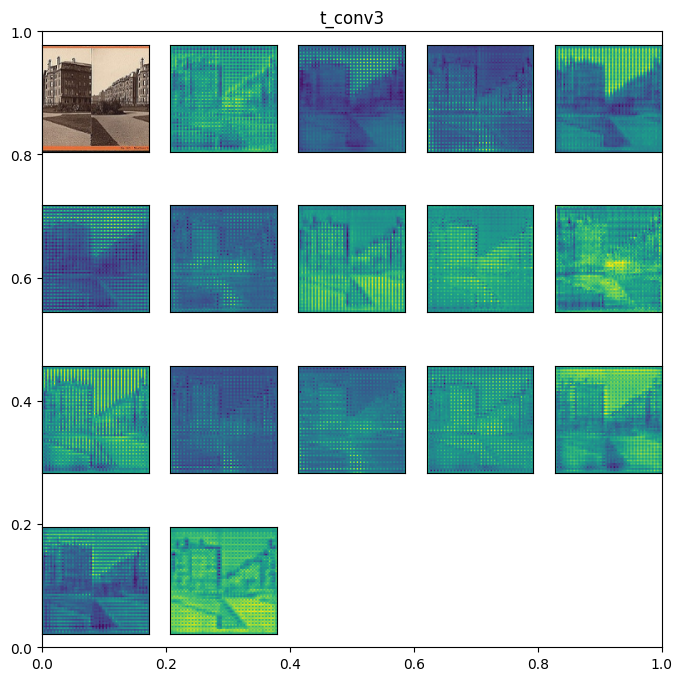

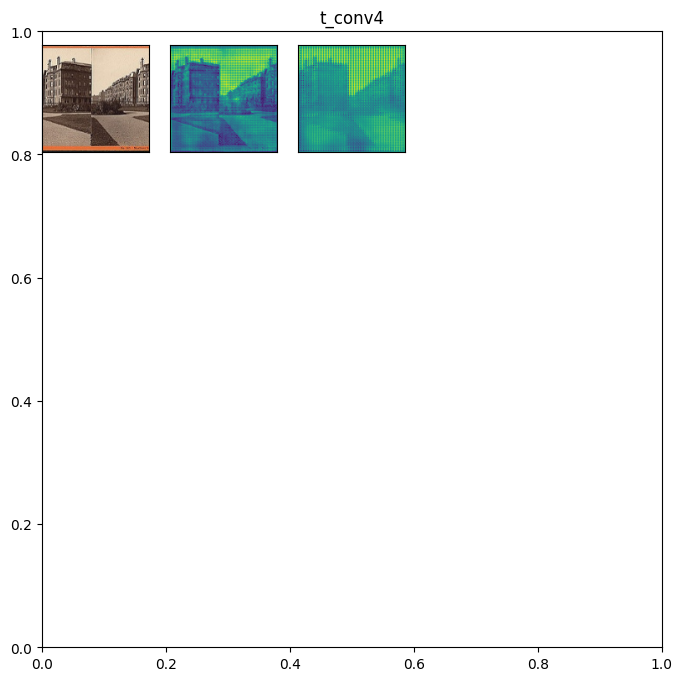

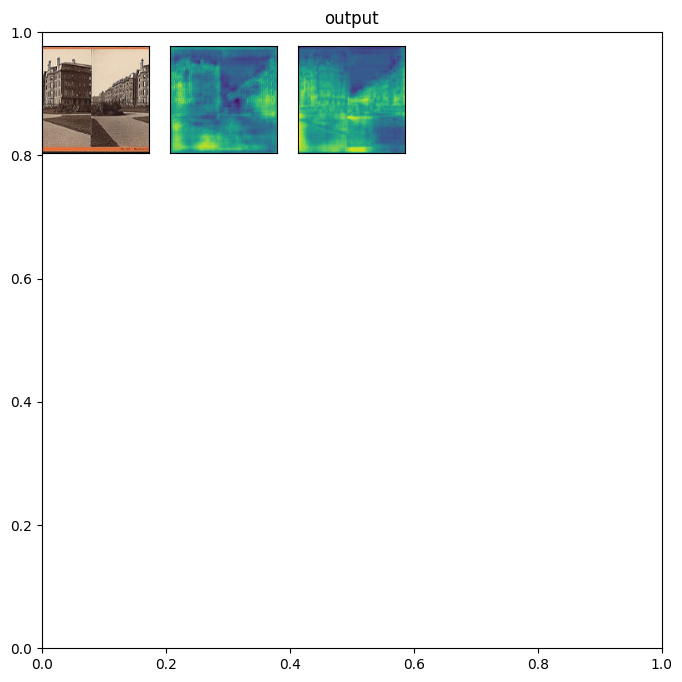

In [9]:

test_model("/kaggle/working/cnn_new_0.001_full.pt", "cnn_testing", "/kaggle/input/intel-image-classification/seg_test/seg_test", None)

render_layer_output("/kaggle/working/cnn_new_0.001_full.pt" , "", "/kaggle/input/intel-image-classification/seg_train/seg_train", 16)